# Portfolio Optimization

## Introduction

Consider the following scenario: Xiaoming, an astute individual, possesses a sum of money represented by $B$ and is contemplating investing it in the stock market. The market comprises of $n$ shares, each having an identical price. Xiaoming's objective is to maximize returns while minimizing risk, taking into account the varying levels of risk tolerance among individuals. Xiaoming's personal risk tolerance is represented by $p$. In light of these considerations, the question arises: which shares should Xiaoming choose to construct an optimal portfolio?

Xiaoming's predicament falls under the purview of portfolio optimization problems. These problems are classified as Quadratic Unconstrained Binary Optimization (QUBO) problems, wherein binary numbers are utilized to represent decisions. In this case, "1" signifies selection, while "0" denotes the opposite. To address the challenge of portfolio optimization, the Quantum Approximate Optimization Algorithm (QAOA) is employed.

## Solving portfolio optimization problems with QAOA

In a simple boolean Markowitz portfolio optimization problem, we wish to solve 

$$\min_{x\in\{0,1\}^n}\quad q x^T \Sigma x - \mu^T x$$

subject to a constraint

$$ 1^T x = B$$

where 
* $n$: number of assets under consideration
* $q > 0 $: risk-appetite
* $\Sigma \in \mathbb{R}^{n\times n}$: covariance matrix of the assets
* $\mu\in\mathbb{R}^n$: mean return of the assets
* $B$: budget (i.e., total number of assets out of $n$ that can be selected)

Our first step is to convert this constrained quadratic programming problem into a QUBO.  We do this by adding a penalty factor $t$ and consider the alternative problem:

$$ \min_{x\in\{0,1\}^n}\quad q x^T \Sigma x - \mu^Tx  + t(1^Tx-B)^2$$

The variables in the linear terms $\mu^Tx = \mu_1 x_1 + \mu_2 x_2+\ldots$ can all be written in a squared form, since all boolean variables $0^2=0,\ 1^2=1$. The same trick is applied on the middle term of $t(1^Tx-B)^2$. Then the function is written as

$$\min_{x\in\{0,1\}^n}\quad q x^T \Sigma x - \sum_{i=1}^n\mu_i x_i^2  + t(1^Tx-B)^2$$

which is a QUBO problem

$$\min_{x\in\{0,1\}^n}\quad x^T Q X + tB^2$$

where matrix $Q$ is

$$ Q = q\Sigma -\mu\begin{pmatrix}1 & \\ & 1\\ & & \ddots\end{pmatrix} + t\begin{pmatrix}1 -2B & 1 & \ldots & 1 \\
1 & 1-2B & 1 & \ldots \\1 & 1 & 1-2B \\
\vdots\end{pmatrix}$$

and we ignore the constant term $t B^2$. We can now solve this by QAOA as above.

## Set up

In [2]:
import tensorcircuit as tc
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output
from functools import partial
import time
import scipy.optimize as optimize

from tensorcircuit.templates.ansatz import QAOA_ansatz_for_Ising
from tensorcircuit.templates.conversions import QUBO_to_Ising
from tensorcircuit.applications.optimization import QUBO_QAOA, QAOA_loss
from tensorcircuit.applications.finance.portfolio import StockData, QUBO_from_portfolio

K = tc.set_backend("tensorflow")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Import data

To optimize a portfolio, it is essential to utilize historical data from various stocks within the same time frame. Websites such as [Nasdaq](Nasdaq.com) and [Yahoo Finance](https://finance.yahoo.com/) provide access to such data. The next step involves transforming this data into an annualized return ($\mu$) and covariance matrix ($\sigma$), which can be recognized by the Quantum Approximate Optimization Algorithm (QAOA). To simplify this process, we can utilize the `StockData` class. This class performs the necessary calculations for annualized return and covariance, as outlined in this [paper](https://doi.org/10.1007/s11128-022-03766-5). They are:

$$
\mu = \left[\prod ^m_{k=1}\left(1+r_k^{(i)}\right)\right]^{\frac{252}{m}}\\
\sigma_{ij}=\frac{252}{m}\sum^m_{k=1}\left(r_k^{(i)}-\overline{r^{(i)}}\right)\left(r_k^{(j)}-\overline{r^{(j)}}\right)
$$

Here is a demonstration of how to use this class:

In [3]:
import random

# randomly generate historical data of 6 stocks in 1000 days
data = [[random.random() for i in range(1000)] for j in range(6)]
stock_data = StockData(data)  # Create an instance

# calculate the annualized return and covariance matrix
mu = stock_data.get_return()
sigma = stock_data.get_covariance()

# some other information can also be obtained from this class
n_stocks = stock_data.n_stocks  # number of stocks
n_days = stock_data.n_days  # length of the time span
daily_change = stock_data.daily_change  # relative change of each day

/Users/felixxu/Library/CloudStorage/OneDrive-ImperialCollegeLondon/文件/Code/TensorCircuit/tensorcircuit/templates/conversions.py:163: RuntimeWarning: invalid value encountered in power
  ret = np.prod(change, axis=1) ** (252 / self.n_days)


In this analysis, we have carefully chosen six prominent stocks: Apple Inc. (AAPL), Microsoft Corporation (MSFT), NVIDIA Corporation (NVDA), Pfizer Inc. (PFE), Levi Strauss & Co. (LEVI), and Cisco Systems, Inc. (CSCO). We acquired their historical data spanning from 09/07/2022, to 09/07/2023 from Yahoo finance. Here are the return and covariance associated with this dataset

In [4]:
# real-world stock data, calculated using the class above
# stock name: aapl, msft, nvda, pfe, levi, csco
# from 09/07/2022 to 09/07/2023
mu = [1.21141, 1.15325, 2.06457, 0.63539, 0.63827, 1.12224]

sigma = np.array(
    [
        [0.08488, 0.06738, 0.09963, 0.02124, 0.05516, 0.04059],
        [0.06738, 0.10196, 0.11912, 0.02163, 0.0498, 0.04049],
        [0.09963, 0.11912, 0.31026, 0.01977, 0.10415, 0.06179],
        [0.02124, 0.02163, 0.01977, 0.05175, 0.01792, 0.02137],
        [0.05516, 0.0498, 0.10415, 0.01792, 0.19366, 0.0432],
        [0.04059, 0.04049, 0.06179, 0.02137, 0.0432, 0.05052],
    ]
)

Using this mean and covariance data, we can now define our portfolio optimization problem, convert it to a QUBO matrix, and then extract the pauli terms and weights

In [6]:
q = 0.5  # the risk preference of investor
budget = 4  # Note that in this example, there are 6 assets, but a budget of only 4
penalty =  1.2

Q = QUBO_from_portfolio(sigma, mu, q, budget, penalty)
portfolio_pauli_terms, portfolio_weights, portfolio_offset = QUBO_to_Ising(Q)

## Classical method

We firstly use brutal force to calculate the cost of each combination. It will give us a clue on the performance of QAOA.

In [31]:
def print_Q_cost(Q, wrap=False, reverse=False):
    n_stocks = len(Q)
    states = []
    for i in range(2**n_stocks):
        a = f"{bin(i)[2:]:0>{n_stocks}}"
        n_ones = 0
        for j in a:
            if j == "1":
                n_ones += 1
        states.append(a)

    cost_dict = {}
    for selection in states:
        x = np.array([int(bit) for bit in selection])
        cost_dict[selection] = np.dot(x, np.dot(Q, x))
    cost_sorted = dict(sorted(cost_dict.items(), key=lambda item: item[1]))
    if reverse == True:
        cost_sorted = dict(
            sorted(cost_dict.items(), key=lambda item: item[1], reverse=True)
        )
    num = 0
    print("\n-------------------------------------")
    print("    selection\t  |\t  cost")
    print("-------------------------------------")
    for k, v in cost_sorted.items():
        print("%10s\t  |\t%.4f" % (k, v))
        num += 1
        if (num >= 8) & (wrap == True):
            break
    print("     ...\t  |\t  ...")
    print("-------------------------------------")

In [32]:
print_Q_cost(Q, wrap=True)


-------------------------------------
    selection	  |	  cost
-------------------------------------
    111001	  |	-24.0487
    101101	  |	-23.7205
    111100	  |	-23.6414
    011101	  |	-23.6340
    101011	  |	-23.5123
    011011	  |	-23.4316
    111010	  |	-23.4269
    111101	  |	-23.3742
     ...	  |	  ...
-------------------------------------


### Use QAOA

Here, a standard QAOA ansatz with 12 layers is used. This circuit will be trained for 1200 times.

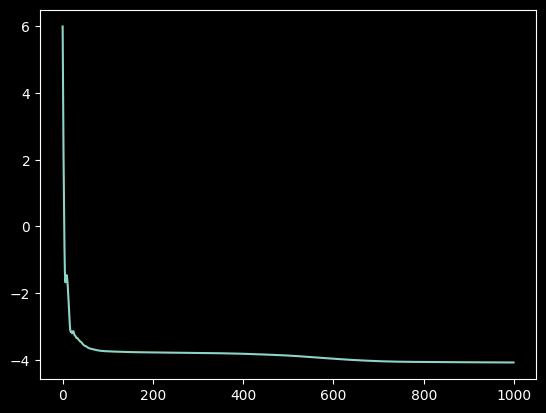

In [33]:
iterations = 1000
nlayers = 12
loss_list = []

# define a callback function to recode the loss
def record_loss(loss, params):
    loss_list.append(loss)

# apply QAOA on this portfolio optimization problem
final_params = QUBO_QAOA(Q, nlayers, iterations, callback=record_loss)

p = plt.plot(loss_list)

Create a function to visualize the results, listing all combinations in descending order of probability.

In [34]:
def print_result_prob(c, wrap=False, reverse=False):
    states = []
    n_qubits = c._nqubits
    for i in range(2**n_qubits):
        a = f"{bin(i)[2:]:0>{n_qubits}}"
        states.append(a)
        # Generate all possible binary states for the given number of qubits

    probs = K.numpy(c.probability()).round(decimals=4)
    # Calculate the probabilities of each state using the circuit's probability method

    sorted_indices = np.argsort(probs)[::-1]
    if reverse == True:
        sorted_indices = sorted_indices[::-1]
    state_sorted = np.array(states)[sorted_indices]
    prob_sorted = np.array(probs)[sorted_indices]
    # Sort the states and probabilities in descending order based on the probabilities

    print("\n-------------------------------------")
    print("    selection\t  |\tprobability")
    print("-------------------------------------")
    if wrap == False:
        for i in range(len(states)):
            print("%10s\t  |\t  %.4f" % (state_sorted[i], prob_sorted[i]))
            # Print the sorted states and their corresponding probabilities
    elif wrap == True:
        for i in range(4):
            print("%10s\t  |\t  %.4f" % (state_sorted[i], prob_sorted[i]))
        print("               ... ...")
        for i in range(-5, -1):
            print("%10s\t  |\t  %.4f" % (state_sorted[i], prob_sorted[i]))
    print("-------------------------------------")

In [35]:
c_final = QAOA_ansatz_for_Ising(
    final_params, nlayers, portfolio_pauli_terms, portfolio_weights
)
print_result_prob(c_final, wrap=True)


-------------------------------------
    selection	  |	probability
-------------------------------------
    111001	  |	  0.1169
    101101	  |	  0.0872
    111100	  |	  0.0823
    101011	  |	  0.0809
               ... ...
    000100	  |	  0.0000
    010000	  |	  0.0000
    000010	  |	  0.0000
    000001	  |	  0.0000
-------------------------------------


The highest probability corresponds to the best combination, thereby ensuring consistency with the classical approach.

## Use XY mixer to improve the performance

In the context of QAOA, XY mixers serve as a specific type of quantum gate to augment the optimization process. XY mixers, which are quantum gates introducing qubit interactions through controlled rotations, enable modification of the quantum system's state. The utilization of XY mixers in QAOA provides several advantages. They facilitate more efficient exploration of the solution space, thereby potentially improving the algorithm's overall performance. Moreover, XY mixers can amplify gradients of the objective function during optimization and enhance quantum circuit depth. Notably, in scenarios like portfolio optimization (covered in another tutorial), where constraints exist, XY mixers preserve the constraints associated with individual combinations while allowing for smooth transitions between them.

It is crucial to consider that the choice of mixers relies on the specific problem under consideration, its unique characteristics, and the quantum hardware available.

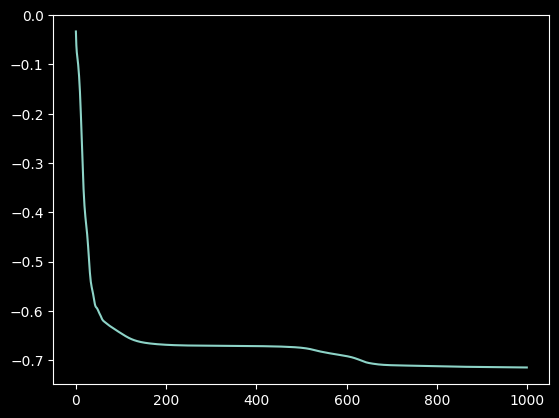

In [38]:
loss_list = []
final_params = QUBO_QAOA(Q, nlayers, iterations, mixer="XY", callback=record_loss)

p = plt.plot(loss_list)

In [39]:
c_final = QAOA_ansatz_for_Ising(
    final_params, nlayers, portfolio_pauli_terms, portfolio_weights, mixer='XY'
)
print_result_prob(c_final, wrap=True)


-------------------------------------
    selection	  |	probability
-------------------------------------
    111001	  |	  0.1553
    001001	  |	  0.1260
    101001	  |	  0.1180
    111000	  |	  0.0934
               ... ...
    100110	  |	  0.0000
    000111	  |	  0.0000
    000101	  |	  0.0000
    000100	  |	  0.0000
-------------------------------------
